<b><h2 style="text-align:center;">COMM493 - Coding AI for Business</h2><b>

<h5 style="text-align:center;">Assignment 1 - Linear Learner Data Identification & Preparation</h5>

<h5 style="text-align:center;">Maxwell Brookes - 20244724</h5>

<h5 style="text-align:center;">Due on Feb 9</h5>


<b><h4>0: Intro</h4><b>
<h5>About The Dataset: asdjklasj klasjkl fjaklsdjfklsjadklf jalskfjklsd j fasdklj fklasjdf ljaslfjsdlfj kadj</h5>
<h5>Goal: asdjklasj klasjkl fjaklsdjfklsjadklf jalskfjklsd j fasdklj fklasjdf ljaslfjsdlfj kadj</h5>


<b><h4>1: Load Modules & Tools:</h4><b>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import logging
import time
import numpy as np  # for linear algebra
import pandas as pd  # for loading data
import sys  # for system information

import seaborn as sns  # for heatmap
import matplotlib.pyplot as plt  # for visualizations

from sklearn.model_selection import train_test_split  # for splitting dataset
from sklearn.feature_selection import VarianceThreshold # for cleaning data
from sklearn.preprocessing import StandardScaler  # for normalizing data

# AWS & SageMaker Libraries for Model Training and Deployment
from botocore.exceptions import ClientError
import boto3
import sagemaker
from sagemaker import Session, get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.amazon.linear_learner import LinearLearner  # SageMaker's built-in Linear Learner algorithm
from sagemaker.inputs import TrainingInput
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Logger Setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print(sys.version)
print("Successfully Loaded All Modules")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[02/07/25 20:40:55] INFO     Found credentials from IAM Role:                                   ]8;id=603974;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=843215;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
Successfully Loaded All Modules



<b><h4>2: Load Dataset:</h4><b>

In [2]:
# dataset = https://www.kaggle.com/datasets/smac91/hotel-bookings, implementation = https://www.kaggle.com/datasets/somnathnaskar/hotel-booking-dataset/data
df = pd.read_csv('hotel_bookings.csv')  # Load the CSV file into a DataFrame
target_column = 'is_canceled'  # define target column (what I want to predict)


<b><h4>3: Preview Dataset:</h4><b>

In [3]:
print('Data Shape:', df.shape)  # print the shape of the data
print('Data Preview:')
print(df.iloc[:10, :5].to_string(index=False))  # list first 10 row and columns

Data Shape: (119390, 32)
Data Preview:
       hotel  is_canceled  lead_time  arrival_date_year arrival_date_month
Resort Hotel            0        342               2015               July
Resort Hotel            0        737               2015               July
Resort Hotel            0          7               2015               July
Resort Hotel            0         13               2015               July
Resort Hotel            0         14               2015               July
Resort Hotel            0         14               2015               July
Resort Hotel            0          0               2015               July
Resort Hotel            0          9               2015               July
Resort Hotel            1         85               2015               July
Resort Hotel            1         75               2015               July



<b><h4>4: Drop Columns:</h4><b>
<h5>'agent' and 'company' because it doe snot matter in this context</h5>
<h5>'arrival_date_week_number' because 'arrival_date_month' and 'arrival_date_day_of_month' are already included</h5>
<h5>'country' because analysis is not based on location</h5>
<h5>'distribution_channel' because it has overlap with 'market_segment'</h5>
<h5>'days_in_waiting_list' because most values are zero</h5>
<h5>'meal' because most values are BB, which implies that all hotels offer the same</h5>
<h5>'reservation_status_date' because the info is already captured with 'lead_time'</h5>
<h5>'reservation_status' conveys the same information as 'is_cancelled'</h5>
<h5>'reserved_room_type' and 'assigned_room_type' because a small kingston business will not have many room options</h5>

In [4]:
# print(df.columns)  # Check available columns
# unique_dict = {col: df[col].unique() for col in df.columns}
# for col, uniques in unique_dict.items():
#     print(f"{col}: {uniques}")

columns_to_drop = ['agent', 'company', 'arrival_date_week_number', 'country', 'distribution_channel', 'days_in_waiting_list', 'meal', 'reservation_status', 'reservation_status_date', 'arrival_date_year', 'arrival_date_day_of_month', 'reserved_room_type', 'assigned_room_type'] # maybe add is_repeated_guest 
df.drop(columns_to_drop, axis=1, inplace=True)  # drop columns without having to create a new pandas data frame

# only use City Hotels
df.drop(df[df['hotel'] == 'Resort Hotel'].index, inplace=True)  # Drop all rows where 'hotel' is 'Resort Hotel'
df.drop(['hotel'], axis=1, inplace=True)  # Drop the 'hotel' column since only 'City Hotel' remains

df.drop_duplicates(keep='first', inplace=True)  # Drop duplicate rows, keeping only the first occurrence

print('Data Shape:', df.shape)

Data Shape: (50680, 18)



<b><h4>5: Encode Categorial Features</h4><b>

In [5]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    if df[col].nunique() > 6:  # Frequency Encoding
        freq_encoding = df[col].value_counts(normalize=True)
        df[col] = df[col].map(freq_encoding)
    else:  # One-Hot Encoding
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df.drop(columns=[col], inplace=True)
        for dummy_col in dummies.columns:
            df[dummy_col] = dummies[dummy_col]
assert len(df.select_dtypes(include=[np.number]).columns) == len(df.columns), "Data contains non-numeric columns."


<b><h4>6: Further Cleaning (Rows, Unrealistic, Outliers, ...):</h4><b>

In [6]:
df['children'].fillna(0, inplace=True)  # Replace NaN values in 'children' with 0

# remove low variance features
selector = VarianceThreshold(threshold=0.01)
df_reduced = selector.fit_transform(df)
selected_features = df.columns[selector.get_support(indices=True)]
df = pd.DataFrame(df_reduced, columns=selected_features)

# remove outliers, value > mean + 3*standard deviation
for col in df.columns:
    upper_limit = df[col].quantile(0.997)
    lower_limit = df[col].quantile(0.003)
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])

assert (df.isnull().values.any() == False), 'Data contains null values.'  # make sure that there are no null values

df.reset_index(drop=True, inplace=True)  # Reset the indicies after all modifications

print('Data Shape:', df.shape)  # print the shape of the data
print('Data Preview:')
print(df.iloc[:10, :5].to_string(index=False))  # list first 10 row and columns

Data Shape: (50680, 18)
Data Preview:
 is_canceled  lead_time  stays_in_weekend_nights  stays_in_week_nights  adults
         0.0        6.0                      0.0                   2.0     1.0
         1.0       88.0                      0.0                   4.0     2.0
         1.0       65.0                      0.0                   4.0     1.0
         1.0       92.0                      2.0                   4.0     2.0
         1.0      100.0                      0.0                   2.0     2.0
         1.0       79.0                      0.0                   3.0     2.0
         0.0        3.0                      0.0                   3.0     1.0
         1.0       63.0                      1.0                   3.0     1.0
         1.0       62.0                      2.0                   3.0     2.0
         0.0       43.0                      0.0                   2.0     2.0



<b><h4>7: Correlation Analysis:</h4><b>
<h5>Unfortuantely no valriables have a strong correlations with 'is_canceled'</h5>
<h5>Target business will have to collect more data as a part of this venture</h5>

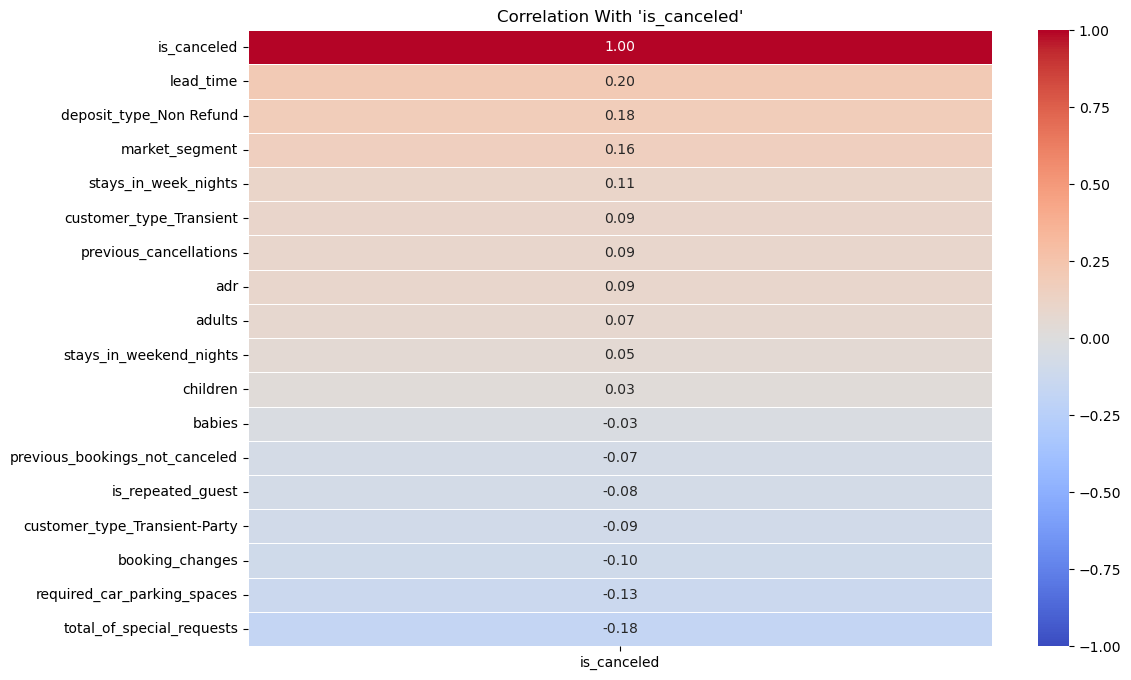

In [7]:
# print('Correlations With \'is_canceled\'')
corr_values = df.corr(numeric_only=True)[target_column].sort_values(ascending=False)
# print(corr_values)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_values.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation With \'is_canceled\'')
plt.show()
plt.close()


<b><h4>8: Split Data For Training and Evaluation:</h4><b>

In [8]:
x = df.drop(columns=[target_column])  # Features (independent variables)
y = df[target_column]  # Target variable (what we want to predict)

x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.2, random_state=42)  # 80/20 split, random_state is fixed for reproducibility 

print(x_train.shape, x_eval.shape, y_train.shape, y_eval.shape)

(40544, 17) (10136, 17) (40544,) (10136,)



<b><h4>9: Prepare SageMakerAI</h4><b>

In [9]:
sagemaker_session = sagemaker.Session()  # Initialize a SageMaker session

role = get_execution_role()  # Get IAM role associated with SageMaker

bucket = sagemaker_session.default_bucket()  # Default S3 bucket assigned by SageMaker
region = sagemaker_session.boto_region_name  # AWS region of the session
prefix = "sagemaker/binary-ames-housing"  # Folder path in S3

train_data = pd.concat([y_train, x_train], axis=1)
validation_data = pd.concat([y_eval, x_eval], axis=1)

# Check for missing values and print a warning if found
if train_data.isnull().values.any() or validation_data.isnull().values.any():
    print("Warning: Missing values detected! Consider handling them before training.")
# Check for class imbalance and print a warning if any class dominates (>75% of the data)
train_class_distribution = y_train.value_counts(normalize=True)
val_class_distribution = y_eval.value_counts(normalize=True)
if train_class_distribution.max() > 0.75 or val_class_distribution.max() > 0.75:
    print("Warning: Class imbalance detected. Consider balancing the dataset.")

# Define filenames for local storage
train_file = "hotel_bookings_train.csv"
validation_file = "hotel_bookings_validation.csv"

# Save training and validation data to CSV files (no headers, no index)
train_data.to_csv(train_file, index=False, header=False)
validation_data.to_csv(validation_file, index=False, header=False)

# Upload datasets to Amazon S3 and retrieve their S3 locations
train_uri = sagemaker_session.upload_data(path=train_file, bucket=bucket, key_prefix=prefix)
validation_uri = sagemaker_session.upload_data(path=validation_file, bucket=bucket, key_prefix=prefix)

# Print the S3 paths of uploaded datasets for reference
print(f"Training data uploaded to: {train_uri}")
print(f"Validation data uploaded to: {validation_uri}")

[02/07/25 20:40:58] INFO     Found credentials from IAM Role:                                   ]8;id=405609;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=688705;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=945407;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=102652;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Training data uploaded to: s3://sagemaker-us-east-1-086946010973/sagemaker/binary-ames-housing/hotel_bookings_train.csv
Validation data uploaded to: s3://sagemaker-us-east-1-086946010973/sagemaker/binary-ames-housing/hotel_bookings_validation.csv



<b><h4>10: Train Binary-Classification Model</h4><b>

In [10]:
"""
This script sets up and launches an AWS SageMaker training job using the Linear Learner algorithm for binary classification.
It retrieves the container image URI, configures the estimator with the required hyperparameters, prepares the training and validation data from S3,
and then initiates the training job.
"""
container = sagemaker.image_uris.retrieve(
    framework="linear-learner",
    region=region  # AWS region, e.g., 'us-west-2'
)

linear_learner = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session
)

num_features = x.shape[1]

# Set hyperparameters for the binary classification task.
# - feature_dim: Number of input features.
# - predictor_type: 'binary_classifier' specifies that this is a binary classification problem.
# - mini_batch_size: Number of samples per mini-batch during training.
linear_learner.set_hyperparameters(
    feature_dim=num_features,
    predictor_type='binary_classifier',
    mini_batch_size=512,  # 32
)

train_input = TrainingInput(s3_data=train_uri, content_type="text/csv")
validation_input = TrainingInput(s3_data=validation_uri, content_type="text/csv")

# The fit method starts the training process on SageMaker using the provided training and validation data.
linear_learner.fit({'train': train_input, 'validation': validation_input})

# Notify the user that model training is complete.
print("Model training complete!")

[02/07/25 20:40:59] INFO     Same images used for training and inference. Defaulting to image     ]8;id=967315;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=836319;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#391\391]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=944877;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=106672;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

[02/07/25 20:41:00] INFO     Found credentials from IAM Role:                                   ]8;id=450138;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=772381;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=644200;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=945589;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=495154;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=41034;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             linear-learner-2025-02-07-20-41-00-730                                                

2025-02-07 20:41:02 Starting - Starting the training job...
..25-02-07 20:41:18 Starting - Preparing the instances for training.
..25-02-07 20:41:42 Downloading - Downloading input data.
.....02-07 20:42:23 Downloading - Downloading the training image.
Docker entrypoint called with argument(s): trainmpleted. Training in progress..
Running default environment configuration script
[02/07/2025 20:43:38 INFO 140354355316544] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insensitivity': '


<b><h4>11: Deploy The Model</h4><b>

In [11]:
session = Session()                 # High-level SageMaker session
sm_client = boto3.client("sagemaker")
endpoint_name = "binary-learner-endpoint"

# -----------------------------------------------------------------------------
# 1. Use built-in waiter for InService (optional, but handy for waiting on creation)
# -----------------------------------------------------------------------------
endpoint_in_service_waiter = sm_client.get_waiter('endpoint_in_service')

def delete_endpoint_and_config(endpoint_name: str, wait_for_deletion: bool = True) -> None:
    """
    Deletes an endpoint and its corresponding endpoint configuration (if they exist).
    Optionally polls until resources are deleted.
    """
    # 1. Delete endpoint (if it exists).
    try:
        endpoint_desc = sm_client.describe_endpoint(EndpointName=endpoint_name)
        endpoint_status = endpoint_desc["EndpointStatus"]

        # If the endpoint is Creating or Updating, wait for it to become InService before deleting.
        if endpoint_status in ("Creating", "Updating"):
            logger.info(f"Endpoint '{endpoint_name}' is in '{endpoint_status}' state. Waiting before delete.")
            endpoint_in_service_waiter.wait(EndpointName=endpoint_name)  # Waits until 'InService'
        
        # Now delete
        logger.info(f"Deleting endpoint: {endpoint_name}")
        sm_client.delete_endpoint(EndpointName=endpoint_name)

    except ClientError as e:
        # If the endpoint was never found, ignore the error. Otherwise, re-raise.
        if e.response['Error']['Code'] == 'ValidationException' and "Could not find" in e.response['Error']['Message']:
            logger.info(f"Endpoint '{endpoint_name}' does not exist or has already been deleted.")
        else:
            raise e

    # 2. Delete endpoint config (if it exists).
    try:
        sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)
        logger.info(f"Deleting endpoint configuration: {endpoint_name}")
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException' and "Could not find" in e.response['Error']['Message']:
            logger.info(f"Endpoint config '{endpoint_name}' does not exist or has already been deleted.")
        else:
            raise e

    # 3. Optionally poll for deletion. (There's no built-in waiter for deletion.)
    #    Below is a simple polling strategy for demonstration.
    if wait_for_deletion:
        logger.info("Waiting for endpoint & configuration to be deleted...")
        for _ in range(30):
            endpoint_exists = True
            endpoint_config_exists = True

            # Check endpoint
            try:
                sm_client.describe_endpoint(EndpointName=endpoint_name)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    endpoint_exists = False

            # Check endpoint config
            try:
                sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    endpoint_config_exists = False

            if not endpoint_exists and not endpoint_config_exists:
                logger.info("Endpoint and endpoint config fully deleted.")
                break

            logger.info("Endpoint or endpoint config still deleting... sleeping 10s.")
            time.sleep(10)
        else:
            logger.warning("Endpoint or endpoint config not fully deleted after 30 checks.")

def delete_model(model_name: str, wait_for_deletion: bool = True) -> None:
    """
    Deletes a SageMaker model if it exists. Optionally waits until it disappears.
    """
    try:
        sm_client.describe_model(ModelName=model_name)
        logger.info(f"Deleting model: {model_name}")
        sm_client.delete_model(ModelName=model_name)
    except ClientError as e:
        if "Could not find" in e.response["Error"]["Message"]:
            logger.info(f"Model '{model_name}' does not exist or is already deleted.")
        else:
            raise e

    if wait_for_deletion:
        # There's no official 'model deleted' waiter, so we poll:
        for _ in range(20):
            try:
                sm_client.describe_model(ModelName=model_name)
                logger.info("Model still deleting... sleeping 5s.")
                time.sleep(5)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    logger.info("Model fully deleted.")
                    break
        else:
            logger.warning("Model was not deleted after waiting.")


delete_endpoint_and_config(endpoint_name)
# If your model is also named the same, you might do:
# delete_model(endpoint_name)

predictor = linear_learner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name
)

predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

logger.info(f"Endpoint '{endpoint_name}' deployed successfully and ready for inference.")

[02/07/25 20:45:50] INFO     Deleting endpoint: binary-learner-endpoint                            ]8;id=909295;file:///tmp/ipykernel_731/3248555513.py\3248555513.py]8;;\:]8;id=61317;file:///tmp/ipykernel_731/3248555513.py#26\26]8;;\

                    INFO     Deleting endpoint configuration: binary-learner-endpoint              ]8;id=796801;file:///tmp/ipykernel_731/3248555513.py\3248555513.py]8;;\:]8;id=550749;file:///tmp/ipykernel_731/3248555513.py#39\39]8;;\

                    INFO     Waiting for endpoint & configuration to be deleted...                 ]8;id=372903;file:///tmp/ipykernel_731/3248555513.py\3248555513.py]8;;\:]8;id=164177;file:///tmp/ipykernel_731/3248555513.py#50\50]8;;\

                    INFO     Endpoint or endpoint config still deleting... sleeping 10s.           ]8;id=830325;file:///tmp/ipykernel_731/3248555513.py\3248555513.py]8;;\:]8;id=407288;file:///tmp/ipykernel_731/3248555513.py#73\73]8;;\

[02/07/25 20:46:01] INFO     Endpoint and endpoint config fully deleted.                           ]8;id=864596;file:///tmp/ipykernel_731/3248555513.py\3248555513.py]8;;\:]8;id=48560;file:///tmp/ipykernel_731/3248555513.py#70\70]8;;\

                    INFO     Creating model with name: linear-learner-2025-02-07-20-46-01-082       ]8;id=664470;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=457885;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name binary-learner-endpoint             ]8;id=141157;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=974542;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

                    INFO     Creating endpoint with name binary-learner-endpoint                    ]8;id=375639;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=15721;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

--------!

[02/07/25 20:50:33] INFO     Endpoint 'binary-learner-endpoint' deployed successfully and ready   ]8;id=835344;file:///tmp/ipykernel_731/3248555513.py\3248555513.py]8;;\:]8;id=216401;file:///tmp/ipykernel_731/3248555513.py#120\120]8;;\
                             for inference.                                                                        


<b><h4>11: Test Model On Training Data</h4><b>


 **Evaluation Metrics:**
  Accuracy:  0.7675
  Precision: 0.6775
  Recall:    0.4722
  F1 Score:  0.5565

**Classification Report:**
              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84      7004
         1.0       0.68      0.47      0.56      3132

    accuracy                           0.77     10136
   macro avg       0.73      0.69      0.70     10136
weighted avg       0.76      0.77      0.75     10136


**Confusion Matrix (Raw Values):**
[[6300  704]
 [1653 1479]]


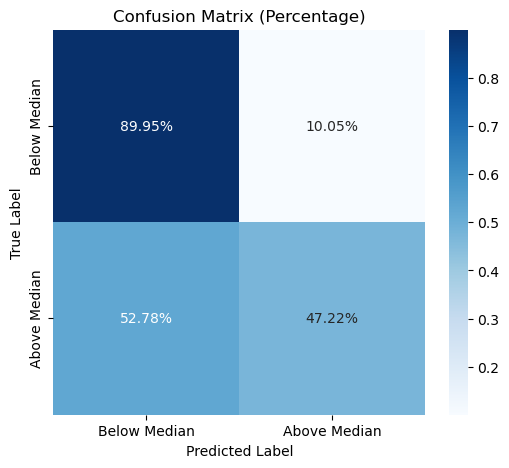

{'Accuracy': 0.7674625098658248, 'Precision': 0.6775080164910673, 'Recall': 0.4722222222222222, 'F1 Score': 0.5565380997177799}


In [12]:
def evaluate_deployed_classifier(predictor, x_eval, y_eval):
    """
    Evaluate the deployed classification model on the test set.

    Fixes:
      - Extracts only 'predicted_label'.
      - Limits printed output for readability.
      - Handles unexpected response formats safely.

    Parameters:
      predictor: SageMaker Predictor object for the deployed model.
      x_eval (pd.DataFrame): Test features.
      y_eval (pd.Series): True labels.

    Returns:
      dict: Evaluation metrics (Accuracy, Precision, Recall, F1 Score)
    """

    # Ensure the predictor uses the correct serialization
    predictor.serializer = CSVSerializer()

    # Copy test features and labels
    X_test = x_eval.copy()
    y_test = y_eval.copy()

    # Get predictions from the deployed endpoint
    predictions = predictor.predict(X_test.values)

    # Ensure correct extraction of predicted labels
    try:
        predicted_labels = [int(result["predicted_label"]) for result in predictions["predictions"]]
    except (KeyError, TypeError) as e:
        print(f"Error extracting predictions: {e}")
        return None  # Stop execution if predictions are not correctly formatted

    # Compute evaluation metrics
    acc = accuracy_score(y_test, predicted_labels)
    prec = precision_score(y_test, predicted_labels, zero_division=0)
    rec = recall_score(y_test, predicted_labels, zero_division=0)
    f1 = f1_score(y_test, predicted_labels, zero_division=0)

    # Print evaluation metrics
    print("\n **Evaluation Metrics:**")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}\n")

    # Print detailed classification report
    print("**Classification Report:**")
    print(classification_report(y_test, predicted_labels))

    # Compute and visualize the confusion matrix
    cm = confusion_matrix(y_test, predicted_labels)
    print("\n**Confusion Matrix (Raw Values):**")
    print(cm)

    # Confusion Matrix with percentages for better readability
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize per class
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues",
                xticklabels=["Below Median", "Above Median"],
                yticklabels=["Below Median", "Above Median"])
    plt.title("Confusion Matrix (Percentage)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Return computed evaluation metrics
    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

# Example call:
# Replace 'predictor', 'x_eval', and 'y_eval' with actual objects
metrics = evaluate_deployed_classifier(predictor, x_eval, y_eval)
print(metrics)


<b><h4>11: Query With Test Data</h4><b>

In [13]:
# Select the first 5 rows from the test set for evaluation.
sample_data = x_eval.head(5)

# Convert the selected data to a NumPy array.
# This format is required by the predictor's CSVSerializer.
input_data = sample_data.values

# Request predictions from the deployed endpoint using the sample data.
predictions = predictor.predict(input_data)

# Process the response if it contains the 'predictions' key.
if "predictions" in predictions:
    # Extract the predicted probabilities from each result.
    y_pred_test_probs = [float(result["score"]) for result in predictions["predictions"]]
    
    # Define a threshold to convert probabilities into binary class labels.
    threshold = 0.5
    # Convert probabilities to binary labels: 1 if above the threshold, else 0.
    y_pred_test_classes = [1 if prob > threshold else 0 for prob in y_pred_test_probs]
    
    print("\nTest Probabilities on 5 samples:", y_pred_test_probs)
    print("Test Predicted Classes on 5 samples:", y_pred_test_classes)
else:
    print("No 'predictions' key found in the response:", predictions)

# Retrieve the actual target values for the selected sample data.
sample_targets = y_eval.loc[sample_data.index]
print("Actual:", sample_targets.tolist())


Test Probabilities on 5 samples: [0.000161654272233136, 0.38858485221862793, 0.2504464089870453, 0.41759154200553894, 0.2590009272098541]
Test Predicted Classes on 5 samples: [0, 0, 0, 0, 0]
Actual: [0.0, 0.0, 0.0, 0.0, 0.0]



<b><h4>11: Delete Sagemaker Cleanup</h4><b>

In [15]:
def delete_sagemaker_endpoint_and_config(sm_client, endpoint_name, endpoint_config_name):
    try:
        sm_client.describe_endpoint(EndpointName=endpoint_name)
        sm_client.delete_endpoint(EndpointName=endpoint_name)
        print(f"Deleted endpoint: {endpoint_name}")
    except sm_client.exceptions.ClientError as e:
        if "Could not find endpoint" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint '{endpoint_name}' does not exist.")
        else:
            raise e
    try:
        sm_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f"Deleted endpoint config: {endpoint_config_name}")
    except sm_client.exceptions.ClientError as e:
        # If the endpoint configuration is not found, inform the user and continue.
        if "Could not find endpoint configuration" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint config '{endpoint_config_name}' does not exist.")
        else:
            raise e

# Automatically delete the endpoint and its configuration.
delete_sagemaker_endpoint_and_config(boto3.client("sagemaker"), 'binary-learner-endpoint', 'binary-learner-endpoint')

Deleted endpoint: binary-learner-endpoint
Deleted endpoint config: binary-learner-endpoint
